In [1]:
import pandas as pd
import os, sys,re
from txt_preprocess import *
from soynlp.noun import LRNounExtractor_v2
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from sklearn.manifold import TSNE
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

#### 데이터 전처리

In [102]:
crpname = '삼성전자'

data = pd.read_excel(crpname+'_report_text2.xlsx')
data.pdf = data.pdf.astype(str)
del data['text']

texts = txt_preprocess2(crpname)
data = pd.merge(data, texts, on='pdf', how='left')

 reading 666th

In [96]:
a = (data.close_val2 - data.close_val)/data.close_val

In [96]:
b = []
for x in a:
    if x > 0.03:
        b.append('up')
    elif x >= -0.03:
        b.append('neu')
    elif x < -0.03:
        b.append('down')
    else:
        b.append(x)

In [96]:
data['label'] = pd.Series(b)

 reading 666th

In [105]:
a = (data.close_val2 - data.close_val)/data.close_val
data['label'] = list(map(lambda x: 1 if x > 0 else 0, a))

In [108]:
df = data[['title','pdf','text','label']].dropna()
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(3)

(658, 4)


,title,pdf,text,label
0,2Q19말 서버 DRAM 수요와 EPS의 상승 전환 예상,1556763948349,목표주가 원 주가 원 시가총액 억원 반도체 디스플레이 박유악 \n주 주가동향 최고...,0
1,낮아진 실적 기대와 추가 주주 환원 가능성,1556762288984,삼성전자 낮아진 실적 기대와 추가 주주 환원 가능성 영업이익 조원 으로 기대 이하...,0
2,경칩(驚蟄)이 지났다. 이미 봄이다.,1556761385663,추정치는 반도체 조원 조원 조원 년 배당수익률 예상 조원이다\n 반도체는 감익이다...,0


In [110]:
df.to_excel('삼성전자_rpt2.xlsx', index=False)

#### Tokenize

In [5]:
texts = [re.sub('\n','  ',txt) for txt in df['text']]

noun_extractor = LRNounExtractor_v2(verbose=True, extract_compound=True)
nouns = noun_extractor.train_extract(texts)
noun_scores = {noun:score.score for noun, score in nouns.items()}

word_extractor = WordExtractor(min_frequency=3, min_cohesion_forward=0.1, min_right_branching_entropy=0.1)
word_extractor.train(texts)
words = word_extractor.extract()

cohesion_score = {word:score.cohesion_forward for word, score in words.items()}

combined_scores = {noun:score + cohesion_score.get(noun, 0)
    for noun, score in noun_scores.items()}

combined_scores = combined_scores.update(
    {subword:cohesion for subword, cohesion in cohesion_score.items()
    if not (subword in combined_scores)}
)

ltokenizer = LTokenizer(scores=combined_scores)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=1260, neg=1173, common=12
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 37956 from 653 sents. mem=0.142 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=443377, mem=0.198 Gb
[Noun Extractor] batch prediction was completed for 13574 words
[Noun Extractor] checked compounds. discovered 3548 compounds
[Noun Extractor] postprocessing detaching_features : 8000 -> 7220
[Noun Extractor] postprocessing ignore_features : 7220 -> 7188
[Noun Extractor] postprocessing ignore_NJ : 7188 -> 7173
[Noun Extractor] 7173 nouns (3548 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=0.212 Gb                    
[Noun Extractor] 82.48 % eojeols are covered
training was done. used memory 0.275 Gby 0.220 Gb
all cohesion probabilities was computed. # words = 27871
all branching entropies was computed # words = 30556
all accessor 

#### Tokenizer test

In [6]:
corpus = [ltokenizer.tokenize(sent, remove_r=True) for sent in df['text'][:1]]

In [10]:
len(corpus)

NameError: name 'corpus' is not defined

In [7]:
c,d = [], []
#stopwords=['조원','대한','조원에','된다','등이']
for doc in corpus:
    doc = sorted(doc)
    for word in doc:
        dd = [w[:-1] for w in d]
        word = re.sub('이다|는|으로|는데|면서|을|되어|되었다|된다|까지|이라면|이었다|조원|대한|등이', '', word)
        if len(word) >= 2: # and word not in stopwords
            if word[:-1] in d:
                d.append(word[:-1])
            else:
                d.append(word)
    c.append(d)
corpus = c

In [8]:
from collections import Counter
sorted(Counter(corpus[0]).items(), key=(lambda x: x[1]), reverse = True)

[('실적', 8),
 ('반도체', 6),
 ('삼성전자', 6),
 ('영업이익', 6),
 ('부진', 5),
 ('추정', 4),
 ('디스플레이', 3),
 ('감액이', 2),
 ('갤럭시', 2),
 ('기대감', 2),
 ('매출액', 2),
 ('발표', 2),
 ('보인다', 2),
 ('상황만', 2),
 ('소폭', 2),
 ('아직', 2),
 ('영업적인', 2),
 ('예상', 2),
 ('예상보다', 2),
 ('유지', 2),
 ('일부', 2),
 ('일회성', 2),
 ('조정', 2),
 ('증가율', 2),
 ('판매량이', 2),
 ('필요', 2),
 ('가격', 1),
 ('가까운', 1),
 ('가능성', 1),
 ('가장', 1),
 ('개선', 1),
 ('겪어야', 1),
 ('견조했데', 1),
 ('경고하', 1),
 ('공시로', 1),
 ('구체적인', 1),
 ('권성률', 1),
 ('그에', 1),
 ('기업분석', 1),
 ('끝났다', 1),
 ('나빠질', 1),
 ('놓고', 1),
 ('단위', 1),
 ('대비', 1),
 ('동반', 1),
 ('따라', 1),
 ('마케팅비용도', 1),
 ('모두', 1),
 ('목표주가', 1),
 ('미치', 1),
 ('반영', 1),
 ('반해', 1),
 ('발표했다', 1),
 ('보면', 1),
 ('불량에', 1),
 ('비용이', 1),
 ('사업부', 1),
 ('삼성물산', 1),
 ('상대기', 1),
 ('상승해', 1),
 ('상황', 1),
 ('선반영', 1),
 ('성과가', 1),
 ('시가총액', 1),
 ('시그널도', 1),
 ('시황', 1),
 ('신중한', 1),
 ('십억원', 1),
 ('억원', 1),
 ('업황부진에', 1),
 ('없어질', 1),
 ('없이', 1),
 ('없지만', 1),
 ('연결', 1),
 ('영업', 1),
 ('영업상황은', 1),
 ('영업적자가', 1),
 ('예견'

### Word2Vec

In [9]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(corpus, size=100, window=5, min_count=2, workers=4, sg=0, sorted_vocab=1)

In [10]:
w2v_model.wv.vocab

{'감액이': <gensim.models.keyedvectors.Vocab at 0x7f1ee2ed8978>,
 '갤럭시': <gensim.models.keyedvectors.Vocab at 0x7f1ee2ed87f0>,
 '기대감': <gensim.models.keyedvectors.Vocab at 0x7f1ee2e5d278>,
 '디스플레이': <gensim.models.keyedvectors.Vocab at 0x7f1ee2e5d400>,
 '매출액': <gensim.models.keyedvectors.Vocab at 0x7f1ee2e5d128>,
 '반도체': <gensim.models.keyedvectors.Vocab at 0x7f1edc036a90>,
 '발표': <gensim.models.keyedvectors.Vocab at 0x7f1edac2def0>,
 '보인다': <gensim.models.keyedvectors.Vocab at 0x7f1edac36278>,
 '부진': <gensim.models.keyedvectors.Vocab at 0x7f1eda9e5470>,
 '삼성전자': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3e10>,
 '상황만': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3e48>,
 '소폭': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3e80>,
 '실적': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3eb8>,
 '아직': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3ef0>,
 '영업이익': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3f28>,
 '영업적인': <gensim.models.keyedvectors.Vocab at 0x7f1eda9f3f60>,
 '예상': <

In [11]:
print(len(w2v_model.wv.vocab))
w2v_model.wv.vectors[:20]

26


array([[ 0.00262184, -0.00459373,  0.00347593, ..., -0.00171366,
        -0.00323791, -0.00494788],
       [-0.00031971,  0.00345498, -0.0043178 , ...,  0.0043185 ,
         0.00106435, -0.00232508],
       [ 0.00322486, -0.00319346, -0.0023408 , ...,  0.00388982,
         0.0027774 , -0.00281402],
       ...,
       [ 0.00497334,  0.00483778,  0.0038623 , ..., -0.00392304,
        -0.00490036,  0.00365385],
       [-0.00222711,  0.00180637, -0.00381445, ...,  0.00493462,
        -0.00337353, -0.00136432],
       [ 0.00299485, -0.00111499,  0.0044896 , ...,  0.00490561,
         0.00151402,  0.00105691]], dtype=float32)

In [115]:
#model_name = 'w2v_model_ss.bin'
#w2v_model.save(model_name, encoding='utf-8')
w2v_model.wv.save_word2vec_format('word2vec.txt', binary=False)

### Doc2Vec

In [12]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [13]:
df.head(2)

,title,pdf,text,label
0,예고된 실적 부진,1554776511972,삼성전자 유지 목표주가 유지 원 현재주가 원 기업분석 반도체 \n예고된 실적 부진...,down
1,수요 충격에서 벗어나기 시작한 반도체 업황,1554693541445,목표주가 원 주가 원 시가총액 억원 반도체 디스플레이 박유악 \n주 주가동향 최고...,down


In [28]:
class Doc2VecCorpus:
    def __init__(self, df):
        self.data = df
    def __iter__(self):
        #with open(self.fname, encoding='utf-8') as f:
        for i in range(len(df)):
            #idx = df.iloc[i]['title'].replace(' ','')[:7] # pdf
            idx = df.iloc[i]['pdf']
            txt = df.iloc[i]['text']
            yield TaggedDocument(
                words = txt.split(), 
                tags = ['%s' % idx])

In [29]:
d2v_corpus = Doc2VecCorpus(df)
d2v_model = Doc2Vec(d2v_corpus)

In [30]:
len(d2v_model.docvecs)

653

In [31]:
d2v_model.most_similar('삼성전자', topn=10)

/home/dsc/anaconda3/envs/gpuenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('반종욱', 0.9520401954650879),
 ('이승우', 0.9465371966362),
 ('삼영전자', 0.9374344348907471),
 ('김록호', 0.9348499178886414),
 ('하나금융투자', 0.9335247278213501),
 ('권성률', 0.9281162023544312),
 ('유의형', 0.9259897470474243),
 ('강정원', 0.9225890636444092),
 ('기아자동차', 0.9164894819259644),
 ('김경민', 0.9158254861831665)]

In [32]:
for idx, doctag in sorted(d2v_model.docvecs.doctags.items(), key=lambda x:x[1].offset)[:10]:
    print(idx, doctag) # offset: data의 row id, word_count: 단어수, doc_count: 한 영화에 학습된 평점수-> 한 리포트에 학습된 문장 수

1554776511972 Doctag(offset=0, word_count=225, doc_count=1)
1554693541445 Doctag(offset=1, word_count=457, doc_count=1)
1554692918116 Doctag(offset=2, word_count=1023, doc_count=1)
1554690698993 Doctag(offset=3, word_count=225, doc_count=1)
1554689532218 Doctag(offset=4, word_count=279, doc_count=1)
1554688883729 Doctag(offset=5, word_count=414, doc_count=1)
1554429380221 Doctag(offset=6, word_count=35, doc_count=1)
1554344603311 Doctag(offset=7, word_count=255, doc_count=1)
1553656388319 Doctag(offset=8, word_count=446, doc_count=1)
1553652631151 Doctag(offset=9, word_count=1520, doc_count=1)


In [33]:
d2v_model.docvecs.most_similar(0)[:5]

[('1554690698993', 0.9106002449989319),
 ('1304298923983', 0.8996686935424805),
 ('1517463753580', 0.8805693984031677),
 ('1501238254900', 0.8574799299240112),
 ('1499652220375', 0.8523223400115967)]

In [34]:
len(d2v_model.docvecs[0])

100

### t-SNE

In [35]:
doc_idx = d2v_model.docvecs.index2entity
X = [d2v_model.docvecs[i] for i in range(len(d2v_model.docvecs))]
print(len(X))
print(X[0][:5])
tsne = TSNE(n_components=2)

653
[-0.05519017  0.11147614  0.00139583 -0.01592634 -0.04904518]


In [53]:
# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100])
df_tsne = pd.DataFrame(X_tsne, index=doc_idx[:100], columns=['x', 'y'])
df_tsne.head()

,x,y
1554776511972,-8.445474,9.464869
1554693541445,-6.758172,10.492128
1554692918116,2.412587,3.835083
1554690698993,-7.634832,9.018347
1554689532218,-5.935259,11.938052


In [81]:
df_viz = df_tsne.reset_index().rename(columns={'index':'pdf'})
df_viz = pd.merge(a, df[['pdf','title','label']])
df_viz['title'] = list(map(lambda x: x.replace(' ','')[:7], df_viz['title']))
df_viz.set_index('title', inplace=True)
del df_viz.index.name
df_viz['lbl'] = list(map(lambda x: 0 if x == 'up' else x, df_viz['label']))
df_viz['lbl'] = list(map(lambda x: 1 if x == 'neu' else x, df_viz['lbl']))
df_viz['lbl'] = list(map(lambda x: 2 if x == 'down' else x, df_viz['lbl']))
df_viz.head()

,pdf,x,y,label,lbl
예고된실적부진,1554776511972,3.185863,8.944927,down,2
수요충격에서벗,1554693541445,1.497921,9.068484,down,2
높아지는주주환,1554692918116,-0.142249,-3.346153,down,2
예고된실적부진,1554690698993,2.726921,8.160638,down,2
예고된실적부진,1554689532218,0.114579,9.832319,down,2


In [92]:
df_viz.iloc[0]['pdf']

'1554776511972'

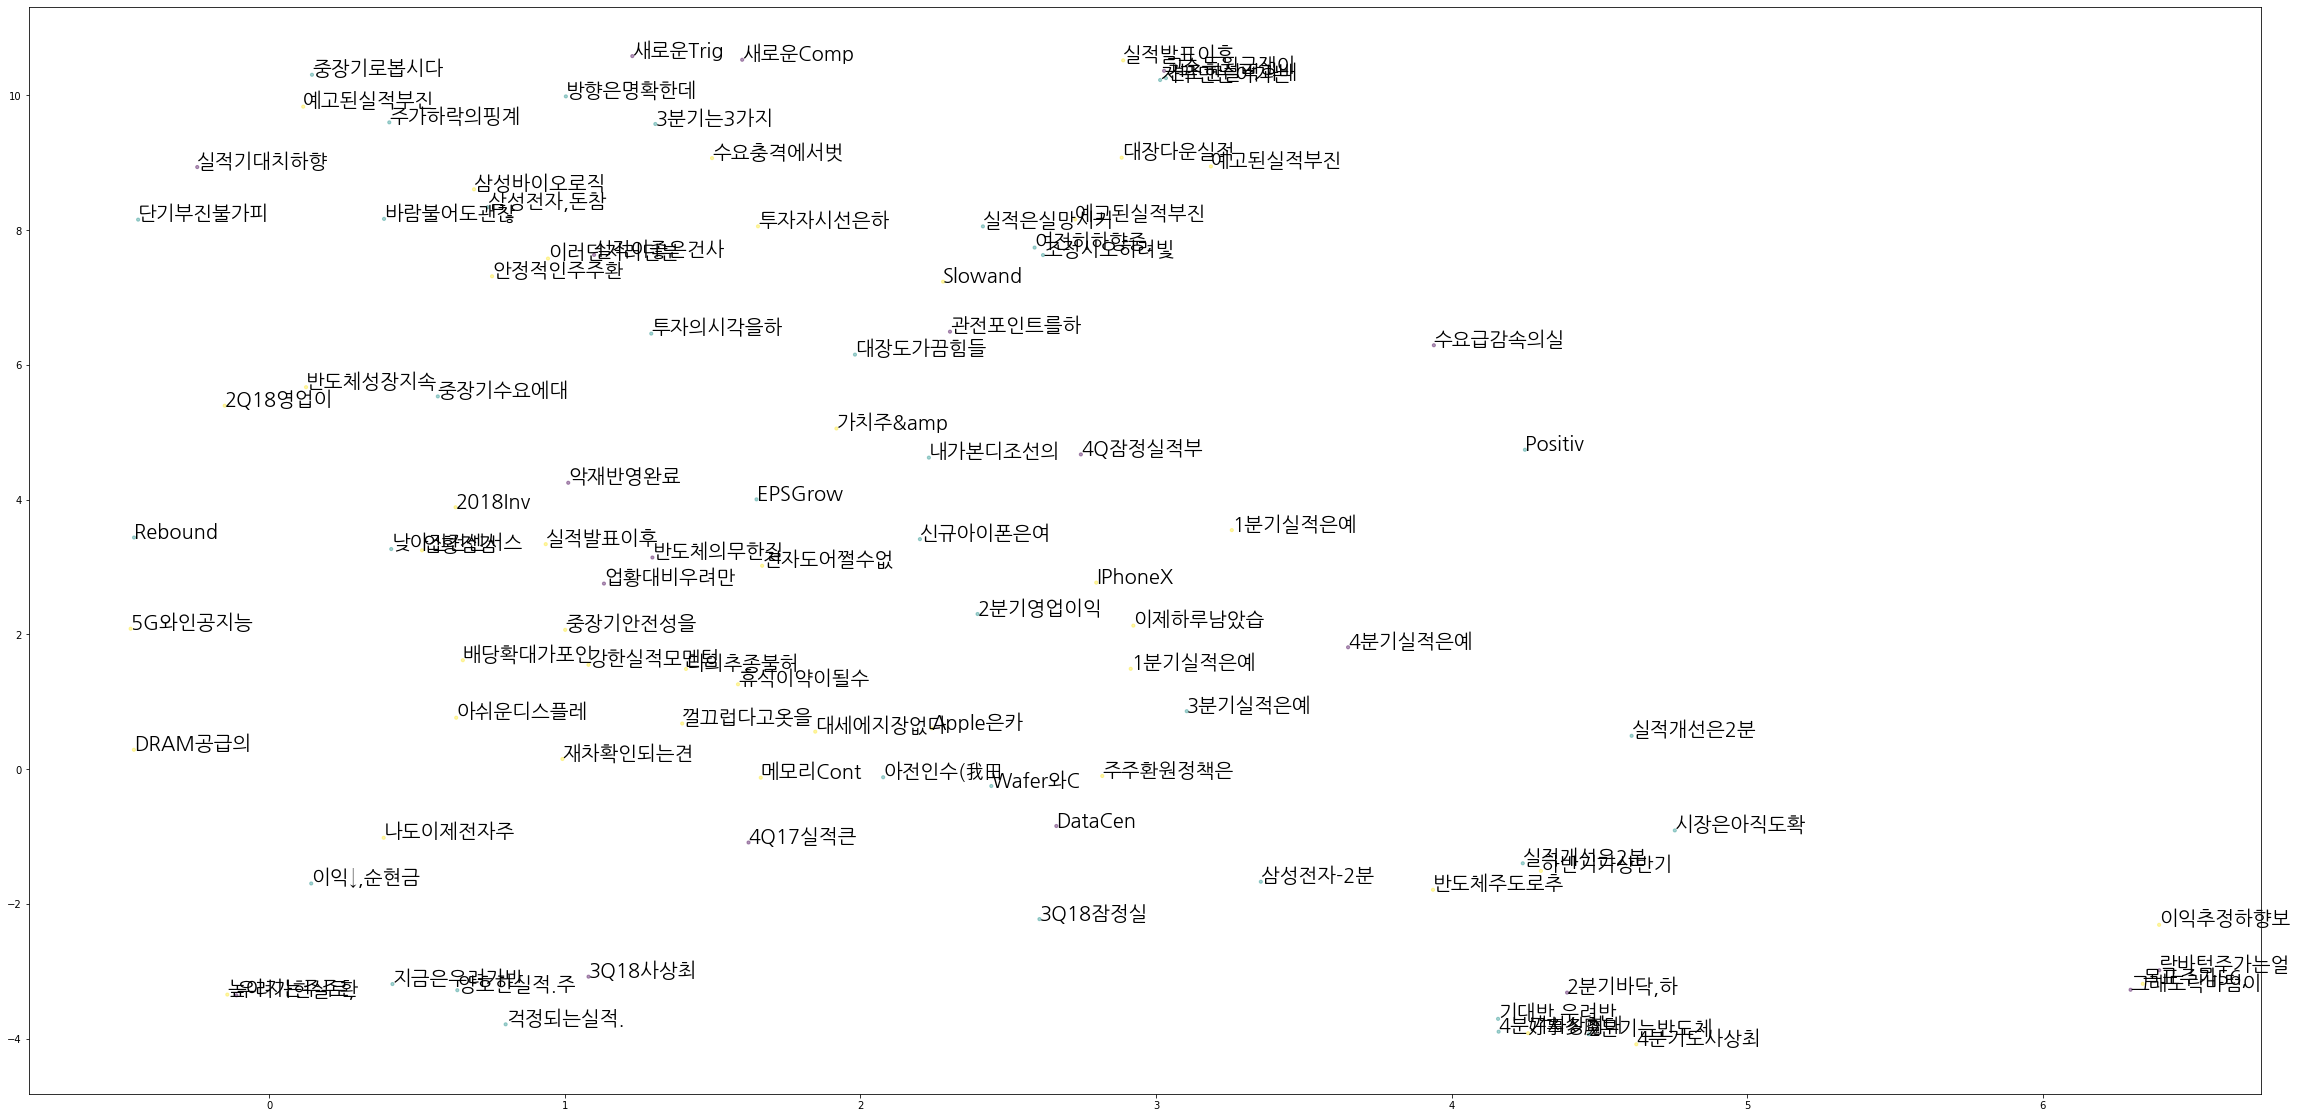

In [95]:
import numpy as np
path = '/usr/share/fonts/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=18)
#plt.rcParams["font.family"] = 'NanumGothic'

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_viz['x'], df_viz['y'], alpha=0.4, c=df_viz['lbl'], s=10)
    
for word, pos in df_viz[['x','y']].iterrows():
    ax.annotate(word, pos, fontsize=20, fontproperties=fontprop)
    
plt.show()